In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt

[**GoogLeNet**](https://arxiv.org/pdf/1409.4842) is a stack of Inception layers. An inception layer is a sub-module that learn different features at different scales (concatenation of different feature maps.)



### Dataset

In [2]:
import numpy as np
import torchvision

import dataset

In [3]:
batch_size = 128

transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=256),
    torchvision.transforms.CenterCrop(size=256),
    torchvision.transforms.ToTensor()
])
data = dataset.ImageNet100(batch_size=batch_size, transforms=transforms)
num_classes = data.num_classes

### Architecture

In [4]:
import model

In [5]:
googlenet = model.GoogLeNet(num_classes=num_classes, clf_dropout=0.4)
googlenet

GoogLeNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layernorm1): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
  (conv2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layernorm2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
  (inception_3a): Inception(
    (branch1): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
    (branch2_1): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
    (branch2_2): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (branch3_1): Conv2d(192, 16, kernel_size=(1, 1), stride=(1, 1))
    (branch3_2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (branch4_1): MaxPool2d(kernel_size=3, stride=1, padding=1, d

In [6]:
def compute_number_params(model):
    num_total_params = 0
    for _, params in model.named_parameters():
        if params.requires_grad:
            num_total_params += params.numel()
    return num_total_params

In [7]:
print("Number of parameters of GoogLeNet:", compute_number_params(googlenet))

Number of parameters of GoogLeNet: 10610780


### Training

Data augmentation was used. As the ImageNet-100 dataset have not fixed-size images, we reshaped the images to 2X6x256 and made random extraction of 224x224 patches. We enable a random horitontal flip of 0.5 probability and normalization accross each RGB channel. Plus we implemented pixel alteration using PCA mentionned in the paper. Actually we used Iterative PCA as the data is very large.

For the training, the setup is (same we used for Alexnet training on Imagenet-100):
- Optimizer: SGD + momentum of $0.9$
- Learning rate is initializd at $0.01$ and divided by $10$ when the valdiation loss stop improving. Weight decay of $0.0005$ is applied for regularization
- Loss: CrossEntropy
- Epochs: 300
- Batch size: 64

Plus we used step learning rate schedule.

In [8]:
with open("googlenet.json", "r") as f:
    logs = json.load(f)
    
train_loss = np.array(list(logs["Loss/train"].values()))
eval_loss = np.array(list(logs["Loss/eval"].values()))
train_acc = np.array(list(logs["Accuracy/train"].values()))
eval_acc = np.array(list(logs["Accuracy/eval"].values()))
max_epochs = logs["max_epochs"]
num_train_batches = logs["num_train_batches"]
epochs = np.arange(num_train_batches-1, max_epochs*num_train_batches+num_train_batches-1, num_train_batches)

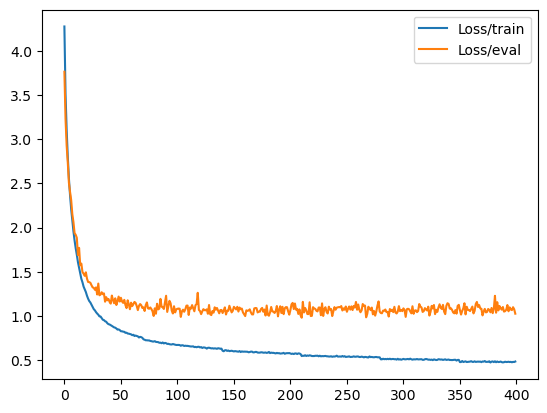

In [9]:
plt.plot(train_loss[epochs], label="Loss/train")
plt.plot(eval_loss, label="Loss/eval")
plt.legend()
plt.show()

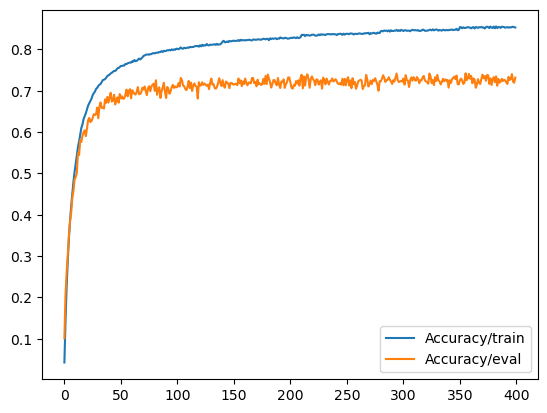

In [10]:
plt.plot(train_acc[epochs], label="Accuracy/train")
plt.plot(eval_acc, label="Accuracy/eval")
plt.legend()
plt.show()

In [11]:
!cat training-googlenet.log  | tail -n 5

2025-09-17 00:23:40 [INFO] [Epoch 252/400] [Step 511532] train_loss: 0.30231, train_acc: 0.90432
2025-09-17 00:24:13 [INFO] [Epoch 252/400] [Step 511632] train_loss: 0.30323, train_acc: 0.90388
2025-09-17 00:24:46 [INFO] [Epoch 252/400] [Step 511732] train_loss: 0.30610, train_acc: 0.90296
2025-09-17 00:25:20 [INFO] [Epoch 252/400] [Step 511832] train_loss: 0.30640, train_acc: 0.90275
2025-09-17 00:25:53 [INFO] [Epoch 252/400] [Step 511932] train_loss: 0.30854, train_acc: 0.90211


We are not far from overfitting. We see that the metrics evolutions are more stable compared to when we trained AlexNet, VGG and NetworkInNetwork

In [12]:
import torch

In [13]:
batch_size = 64

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
googlenet.load_state_dict(torch.load("googlenet.pth"))
googlenet.to(device)
googlenet.eval()
print()

/tmp/ipykernel_115938/3907885004.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  googlenet.load_state_dict(torch.load("googlenet.pth"))


### Topk error

In [14]:
def compute_top_k_error(model, eval_dataloader, k: int=5):
    topk_acc = 0
    num_instances = 0
    for batch in eval_dataloader:
        batch = [a.to(device) for a in batch]
        with torch.no_grad():
            output,_,_ = model(*batch[:-1])
            _, pred = output.topk(k, dim=1)
            topk_acc += (pred==batch[-1].view(-1, 1).expand_as(pred)).any(dim=-1).float().sum().item()
            num_instances += batch[-1].size(0)
    topk_acc /= num_instances
    return topk_acc, 1-topk_acc

In [15]:
for k in range(1, 6, 2):
    topk_acc, topk_error = compute_top_k_error(model=googlenet, eval_dataloader=data.eval_dataloader, k=k)
    print(f"NetworkInNetwork: top{k}_accuracy: {topk_acc:.5f}, top{k}_error: {topk_error:.5f}")

NetworkInNetwork: top1_accuracy: 0.72180, top1_error: 0.27820
NetworkInNetwork: top3_accuracy: 0.87040, top3_error: 0.12960
NetworkInNetwork: top5_accuracy: 0.90860, top5_error: 0.09140


|                                    | Alexnet           | NetworkInNetwork | VGG11            | VGG13                 | VGG16                  | VGG19                     | GoogLeNet
|:-----------------------------------|:------------------|:-----------------|:-----------------|:----------------------|:-----------------------|:--------------------------|:------------
| Number of layers                   | 8                 | 12               | 11               | 13                    | 16                     | 19                        |
| Number of conv layers              | 5                 | 12               | 8                | 10                    | 13                     | 16                        |
| Number of dense layers             | 3                 | 0                | 3                | 3                     | 3                      | 3                         |
| Local repose normalization         | yes               | no               | no               | no                    | no                     | no                        |
| Number of parameters (M)           | ~58.7             | ~4.75            | ~129.1           | ~129.3                | ~134.6                 | ~139.9                    |
| Train max epochs                   | 90                | 90               | 74               | 74                    | 74                     | 74                        |
| Training duration                  | 12 hours 34 mins  | 9 hours 50 mins  | 18 hours 44 mins | 1 day 7 hours 27 mins | 1 day 12 hours 29 mins |                           |
| Top1_acc (%)                       | 68.38             | 66.58            | 74.14            | 76.64                 | **77.20**              |                           |
| Top3_acc (%)                       | 84.24             | 83.20            | 88.10            | 89.82                 | **90.62**              |                           |
| Top5_acc (%)                       | 88.72             | 88.56            | 92.36            | 93.24                 | **93.62**              |                           |

ss